# LightGBM（特徴量エンジニアリングなし×ハイパーパラメータ初期値）

In [ ]:
# # Colabでバージョンを変更するとき、コメントアウトして実行してください
# !pip install pandas==1.5.3
# !pip install numpy==1.22.4
# !pip install matplotlib==3.7.1
# !pip install seaborn==0.12.2
# !pip install scikit-learn==1.2.2
# !pip install lightgbm==3.3.5
# !pip install shap==0.41.0

In [1]:
# ライブラリのインポート
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [2]:
# バージョンの確認
import matplotlib
import sklearn
import lightgbm as lgb
print(pd.__version__) 
print(np.__version__)
print(matplotlib.__version__)
print(sns.__version__)
print(sklearn.__version__) 
print(lgb.__version__)

1.5.3
1.22.4
3.7.1
0.12.2
1.2.2
3.3.5


In [3]:
# データ読み込み、外れ値の除外

# データセットの読み込み
df = sns.load_dataset('diamonds')

# 外れ値除外の前処理
df = df.drop(df[(df['x'] == 0) | (df['y'] == 0)| (df['z'] == 0)].index, axis=0)
df = df.drop(df[(df['x'] >= 10) | (df['y'] >= 10) | (df['z'] >= 10)].index, axis=0)
df.reset_index(inplace=True, drop=True)
print(df.shape)
df.head()

(53911, 10)


,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [4]:
# 特徴量と目的変数の設定
X = df.drop(['price'], axis=1)
y = df['price']

In [5]:
# 学習データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=0)
print('X_trainの形状：', X_train.shape, ' y_trainの形状：', y_train.shape, ' X_testの形状：', X_test.shape, ' y_testの形状：', y_test.shape)

X_trainの形状： (43128, 9)  y_trainの形状： (43128,)  X_testの形状： (10783, 9)  y_testの形状： (10783,)


In [6]:
# テストデータ3件目の特徴量（label encoding前）
X_test.iloc[2]

carat         1.06
cut        Premium
color            D
clarity        SI2
depth         60.9
table         60.0
x             6.55
y             6.52
z             3.98
Name: 6999, dtype: object

In [7]:
# カテゴリ変数のlabel encoding
from sklearn.preprocessing import LabelEncoder

cat_cols = ['cut', 'color', 'clarity']

for c in cat_cols:
    le = LabelEncoder()
    le.fit(X_train[c])
    X_train[c] = le.transform(X_train[c])
    X_test[c] = le.transform(X_test[c])

X_train.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43128 entries, 2640 to 2732
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    43128 non-null  float64
 1   cut      43128 non-null  int64  
 2   color    43128 non-null  int64  
 3   clarity  43128 non-null  int64  
 4   depth    43128 non-null  float64
 5   table    43128 non-null  float64
 6   x        43128 non-null  float64
 7   y        43128 non-null  float64
 8   z        43128 non-null  float64
dtypes: float64(6), int64(3)
memory usage: 3.3 MB


In [8]:
# カテゴリ変数のデータ型をcategory型に変換
cat_cols = ['cut', 'color', 'clarity']

for c in cat_cols:
    X_train[c] = X_train[c].astype('category')
    X_test[c] = X_test[c].astype('category')

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43128 entries, 2640 to 2732
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   carat    43128 non-null  float64 
 1   cut      43128 non-null  category
 2   color    43128 non-null  category
 3   clarity  43128 non-null  category
 4   depth    43128 non-null  float64 
 5   table    43128 non-null  float64 
 6   x        43128 non-null  float64 
 7   y        43128 non-null  float64 
 8   z        43128 non-null  float64 
dtypes: category(3), float64(6)
memory usage: 2.4 MB


In [9]:
# 学習データの一部を検証データに分割
X_tr, X_va, y_tr, y_va = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, random_state=0)
print('X_trの形状：', X_tr.shape, ' y_trの形状：', y_tr.shape, ' X_vaの形状：', X_va.shape, ' y_vaの形状：', y_va.shape)

X_trの形状： (34502, 9)  y_trの形状： (34502,)  X_vaの形状： (8626, 9)  y_vaの形状： (8626,)


In [10]:
# ハイパーパラメータの設定
import lightgbm as lgb

lgb_train = lgb.Dataset(X_tr, y_tr)
lgb_eval = lgb.Dataset(X_va, y_va, reference=lgb_train)

params = {
    'objective': 'mae',
    'seed': 0,
    'verbose': -1,
}

# 誤差プロットの格納用データ
evals_result = {}

In [11]:
# モデルの学習
model = lgb.train(params,
                  lgb_train,
                  num_boost_round=10000,
                  valid_sets=[lgb_train, lgb_eval],
                  valid_names=['train', 'valid'],
                  callbacks=[lgb.early_stopping(100),
                             lgb.log_evaluation(500),
                             lgb.record_evaluation(evals_result)])

y_va_pred = model.predict(X_va, num_iteration=model.best_iteration)
score = mean_absolute_error(y_va, y_va_pred)
print(f'MAE valid: {score:.2f}')

Training until validation scores don't improve for 100 rounds
[500]	train's l1: 230.356	valid's l1: 260.634
[1000]	train's l1: 208.097	valid's l1: 257.966
Early stopping, best iteration is:
[1258]	train's l1: 203.107	valid's l1: 257.68
MAE valid: 257.68


<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='l1'>

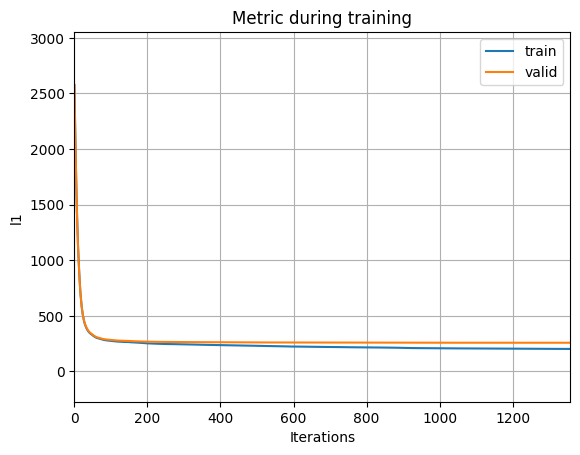

In [12]:
# 学習データと検証データの誤差プロット
lgb.plot_metric(evals_result)

In [13]:
# 学習が停止したブースティング回数
model.best_iteration

1258

In [14]:
# 検証データの予測と評価
y_va_pred = model.predict(X_va, num_iteration=model.best_iteration) 
print('MAE valid: %.2f' % (mean_absolute_error(y_va, y_va_pred)))

MAE valid: 257.68


In [15]:
# テストデータの予測と評価
y_test_pred = model.predict(X_test, num_iteration=model.best_iteration) 
print('MAE test: %.2f' % (mean_absolute_error(y_test, y_test_pred)))

MAE test: 262.61


In [16]:
# テストデータの正解値と予測値の比較
print('正解値：', y_test[:5].values)
print('予測値：', y_test_pred[:5])
print('残差=正解値-予測値：', y_test[:5].values - y_test_pred[:5])

正解値： [3353 2930 4155 2780  684]
予測値： [3357.55731496 2933.55703446 4789.28650622 2939.79413242  748.33015008]
残差=正解値-予測値： [  -4.55731496   -3.55703446 -634.28650622 -159.79413242  -64.33015008]


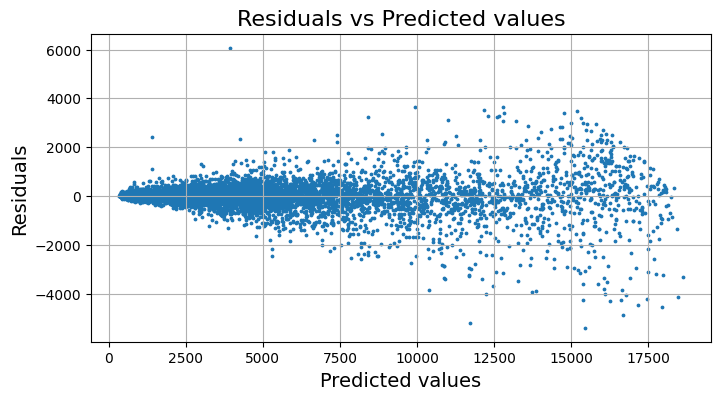

In [17]:
# 残差のプロット

# 残差の計算
residuals = y_test - y_test_pred
# 残差と予測値の散布図
plt.figure(figsize=(8, 4)) #プロットのサイズ指定
plt.scatter(y_test_pred, residuals, s=3)
plt.xlabel('Predicted values', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.title('Residuals vs Predicted values', fontsize=16)
plt.grid()
plt.show()

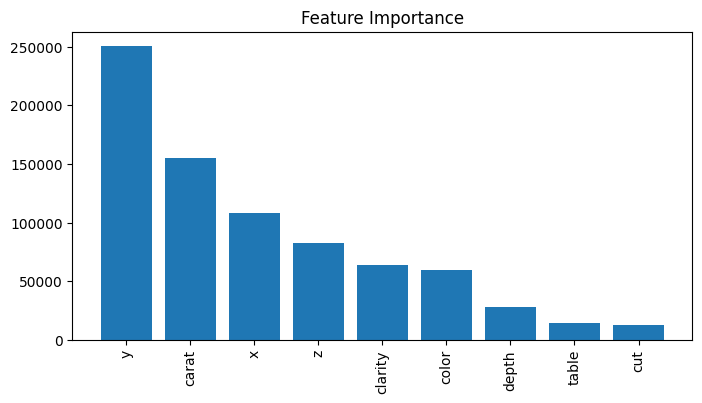

In [18]:
# 特徴量の重要度の可視化
importances = model.feature_importance(importance_type='gain') # 特徴量の重要度
indices = np.argsort(importances)[::-1] # 特徴量の重要度を降順にソート

plt.figure(figsize=(8, 4)) #プロットのサイズ指定
plt.title('Feature Importance') # プロットのタイトルを作成
plt.bar(range(len(indices)), importances[indices]) # 棒グラフを追加
plt.xticks(range(len(indices)), X.columns[indices], rotation=90) # X軸に特徴量の名前を追加
plt.show() # プロットを表示

# SHAP

In [19]:
# ライブラリshapのインストール
!pip install shap


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [20]:
# shapのバージョン確認
import shap
shap.__version__

/home/takuya/.cache/pypoetry/virtualenvs/lightgbm-sample-qPUWcycm-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'0.41.0'

In [21]:
# explainerの作成
import shap
explainer = shap.TreeExplainer(
    model = model,
    feature_perturbation = 'tree_path_dependent')

In [22]:
# SHAP値の計算
shap_values = explainer(X_test)

In [23]:
# テストデータの予測値
y_test_pred

array([3357.55731496, 2933.55703446, 4789.28650622, ...,  596.68289062,
        461.34164749,  611.27708734])

In [24]:
# 3件目の予測値
y_test_pred[2]

4789.286506223028

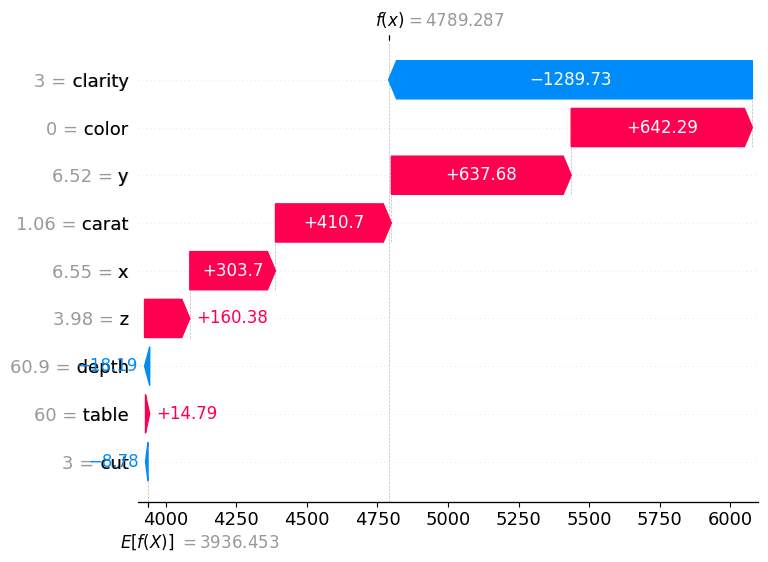

In [25]:
# 3件目のSHAP値の可視化
shap.plots.waterfall(shap_values[2])

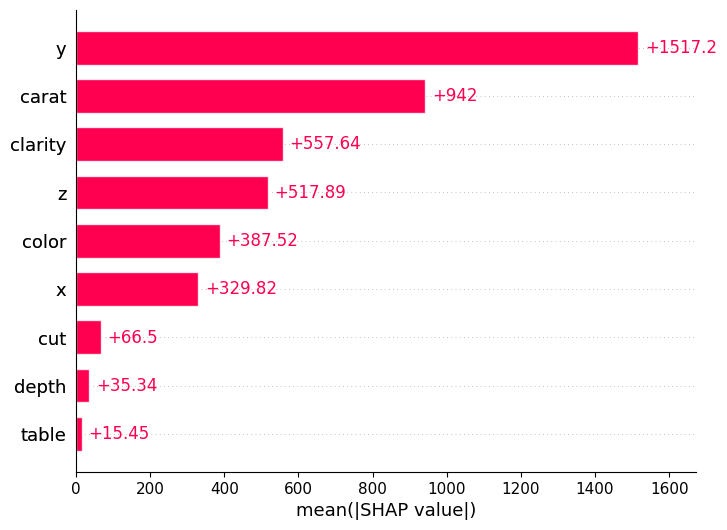

In [26]:
# 重要度の可視化
shap.plots.bar(shap_values)

# クロスバリデーション

In [27]:
# クロスバリデーション
from sklearn.model_selection import KFold

params = {
    'objective': 'mae',
    'seed': 0,
    'verbose': -1,
}

# 格納用データの作成
valid_scores = []
models = []
oof = np.zeros(len(X_train))

# KFoldを用いて学習データを5分割してモデルを作成
kf = KFold(n_splits=5, shuffle=True, random_state=0)
for fold, (tr_idx, va_idx) in enumerate(kf.split(X_train)):
    X_tr = X_train.iloc[tr_idx]
    X_va = X_train.iloc[va_idx]
    y_tr = y_train.iloc[tr_idx]
    y_va = y_train.iloc[va_idx]
    
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_va, y_va, reference=lgb_train)

    model = lgb.train(params,
                      lgb_train,
                      num_boost_round=10000,
                      valid_sets=[lgb_train, lgb_eval],
                      valid_names=['train', 'valid'],
                      callbacks=[lgb.early_stopping(100),
                                 lgb.log_evaluation(500)])
    
    y_va_pred = model.predict(X_va, num_iteration=model.best_iteration)
    score = mean_absolute_error(y_va, y_va_pred)
    print(f'fold {fold+1} MAE valid: {score:.2f}')
    print('')

    # スコア、モデル、予測値の格納
    valid_scores.append(score)
    models.append(model)
    oof[va_idx] = y_va_pred

# クロスバリデーションの平均スコア
cv_score = np.mean(valid_scores)
print(f'CV score: {cv_score:.2f}')

Training until validation scores don't improve for 100 rounds
[500]	train's l1: 230.356	valid's l1: 260.634
[1000]	train's l1: 208.097	valid's l1: 257.966
Early stopping, best iteration is:
[1258]	train's l1: 203.107	valid's l1: 257.68
fold 1 MAE valid: 257.68

Training until validation scores don't improve for 100 rounds
[500]	train's l1: 227.67	valid's l1: 267.78
[1000]	train's l1: 214.526	valid's l1: 264.82
Early stopping, best iteration is:
[1373]	train's l1: 205.323	valid's l1: 264.019
fold 2 MAE valid: 264.02

Training until validation scores don't improve for 100 rounds
[500]	train's l1: 227.854	valid's l1: 268.653
[1000]	train's l1: 212.041	valid's l1: 266.975
Early stopping, best iteration is:
[976]	train's l1: 212.466	valid's l1: 266.921
fold 3 MAE valid: 266.92

Training until validation scores don't improve for 100 rounds
[500]	train's l1: 231.676	valid's l1: 272.794
[1000]	train's l1: 212.137	valid's l1: 268.951
[1500]	train's l1: 201.575	valid's l1: 267.066
Early stopping

In [28]:
# foldごとの検証データの誤差
valid_scores

[257.6803136357446,
 264.0191748647657,
 266.9213824925146,
 266.61596704243175,
 265.26537176018445]

In [29]:
# 検証データの誤差平均
print('MAE CV: %.2f' % (
      mean_absolute_error(y_train, oof)))

MAE CV: 264.10


# 予測モデルの平均値

In [30]:
# モデルごとのテストデータの予測
preds = []
for model in models:
  # クロスバリデーションで作成したモデルで予測
  y_test_pred = model.predict(X_test, num_iteration=model.best_iteration)
  preds.append(y_test_pred)

y_test_preds = np.array(preds)
print('モデルごとの予測：', y_test_preds.shape)
print(y_test_preds)

モデルごとの予測： (5, 10783)
[[3357.55731496 2933.55703446 4789.28650622 ...  596.68289062
   461.34164749  611.27708734]
 [3046.89423838 3009.72448027 4783.18206834 ...  615.30171861
   456.22082331  627.25542305]
 [3194.00064914 3034.97563635 4747.57165566 ...  618.65409256
   452.95556076  627.44648992]
 [3281.33379662 3051.24444092 4787.61204173 ...  595.67280357
   453.43456254  635.09512176]
 [3010.85446123 3028.76361108 4697.9380019  ...  622.24429962
   454.05096045  637.08895486]]


In [31]:
# 全モデルの予測平均
y_test_pred_mean = np.mean(y_test_preds ,axis=0)
print('全モデルの予測平均：', y_test_pred_mean.shape)
print(y_test_pred_mean)

全モデルの予測平均： (10783,)
[3178.12809207 3011.65304062 4761.11805477 ...  609.71116099  455.60071091
  627.63261539]


In [32]:
# 正解と予測平均の誤差
print('MAE test: %.2f' % (
      mean_absolute_error(y_test, y_test_pred_mean)))

MAE test: 254.55
